In [1]:
import helper_functions

In [2]:
from scipy.spatial import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import preprocessing
from matplotlib.ticker import MaxNLocator

In [7]:
def extract_connectivity_mat(dataset_key):
    dat = pd.read_csv('../Data/'+dataset_key+'.csv')
    dat = dat.drop(columns=['other'])
    unnamed_cols = list(dat.columns[np.where(np.array(['Unnamed' in col for col in dat.columns]) == True)[0]])
    dat = dat.drop(columns=unnamed_cols)
    dat = dat.rename(columns={"vc3": "vc3l", 'vm7':'vm7d', '1':'vm7v'})
    dat = dat.sort_index(axis='columns')
    dat = dat.replace(np.nan, int(0))
    dat = dat > 0
    dat = dat.astype(int)

    return dat

In [8]:
W_Ellis_Mel_F = extract_connectivity_mat('Ellis_DMel_female')
W_Ellis_Mel_M = extract_connectivity_mat('Ellis_DMel_male')
W_Ellis_Sech = extract_connectivity_mat('Ellis_DSec_female')
W_Ellis_Sim = extract_connectivity_mat('Ellis_DSim_female')

In [9]:
def PCA_w_shuffles(dataset_key, shuffle_key, n_components=20, n_shuffles=1000):
    W = extract_connectivity_mat(dataset_key)

    lbl = dataset_key + '_' + shuffle_key
    
    # run PCA on original data
    W_ = np.copy(W)
    pca = PCA(n_components = n_components) 
    covar_matrix = pca.fit(W_)
    variances = covar_matrix.explained_variance_ratio_ # Var ratios

    # run PCA on random shuffles
    shuffle = getattr(helper_functions, shuffle_key)
    variances_rand_list = []
    for i in range(n_shuffles):
        W_rand = shuffle(W, W)
        pca_rand = PCA(n_components = n_components)
        covar_matrix_rand = pca_rand.fit(W_rand)
        variances_rand = covar_matrix_rand.explained_variance_ratio_ # Var ratios
        variances_rand_list.append(variances_rand)

    variances_rand_list = np.array(variances_rand_list) # (n, PC_components)
    variances_mean = np.mean(variances_rand_list, axis=0)

    # confidence intervals
    lowers = []
    highers = []
    for i in range(n_components):
        lower, higher = helper_functions.confidence_interval(variances_rand_list[:, i])
        lowers.append(lower)
        highers.append(higher)
    errors = np.array([variances_mean-lowers, highers-variances_mean])

    df_TO = pd.DataFrame(data={"component":range(n_components), "variance explained "+dataset_key:variances, "variance explained "+shuffle_key: variances_mean, "confidence interval lower":lowers, "confidence interval higher":highers})

    df_TO.to_csv("pca_"+lbl+".csv")

    # plotting
    fig = plt.figure(figsize=(5,3))
    ax1 = fig.add_subplot(111)

    ax1.scatter(range(n_components), variances, label=dataset_key)
    ax1.scatter(range(n_components), variances_mean, label=shuffle_key)
    ax1.errorbar(range(n_components), variances_mean, errors, fmt='none')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.ylabel('Fraction Variance Explained')
    plt.xlabel('Component')
    plt.title(lbl)


    plt.legend()
    plt.savefig(lbl+".png")
    plt.show()


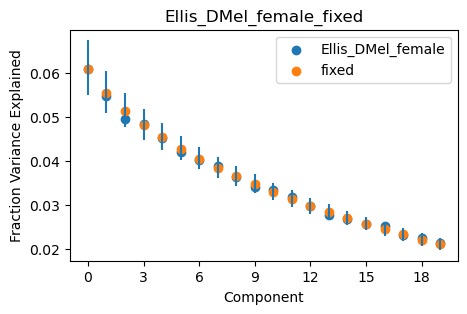

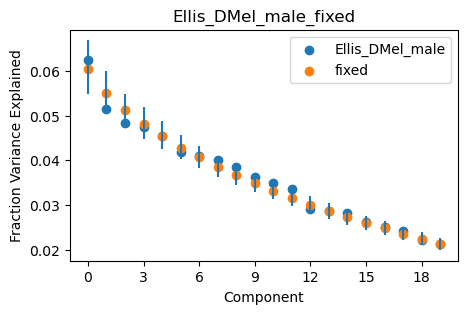

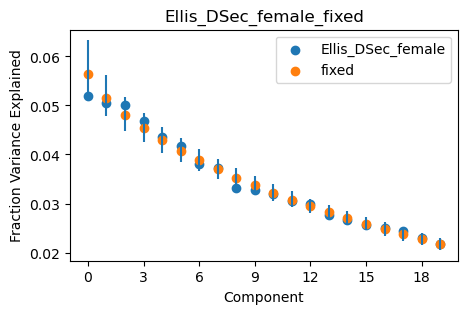

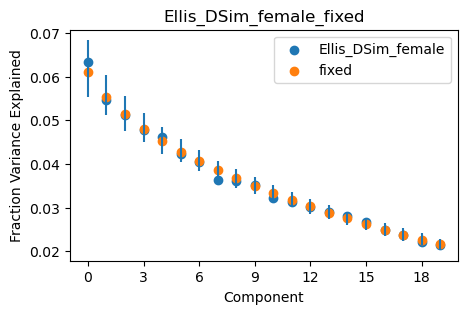

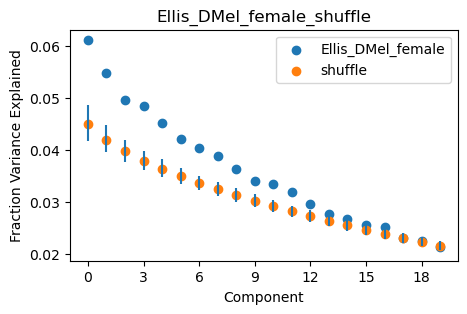

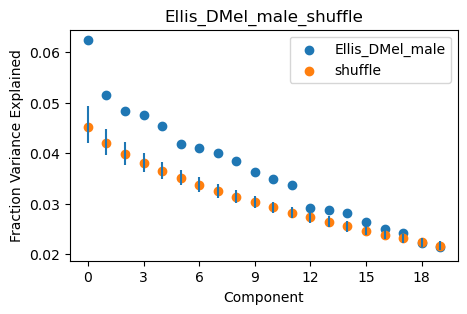

In [10]:
PCA_w_shuffles('Ellis_DMel_female', 'fixed', n_components=20)
PCA_w_shuffles('Ellis_DMel_male', 'fixed', n_components=20)
PCA_w_shuffles('Ellis_DSec_female', 'fixed', n_components=20)
PCA_w_shuffles('Ellis_DSim_female', 'fixed', n_components=20)
PCA_w_shuffles('Ellis_DMel_female', 'shuffle', n_components=20)
PCA_w_shuffles('Ellis_DMel_male', 'shuffle', n_components=20)
PCA_w_shuffles('Ellis_DSec_female', 'shuffle', n_components=20)
PCA_w_shuffles('Ellis_DSim_female', 'shuffle', n_components=20)

Sanity check: replicating Larry's PCA analysis in Caron et al. 2013

In [11]:
dat = pd.read_csv('data/caron2013.csv')
dat = dat.drop(columns=['other'])

In [12]:
dat.shape

(200, 53)

Text(0, 0.5, 'Percent Variance (%)')

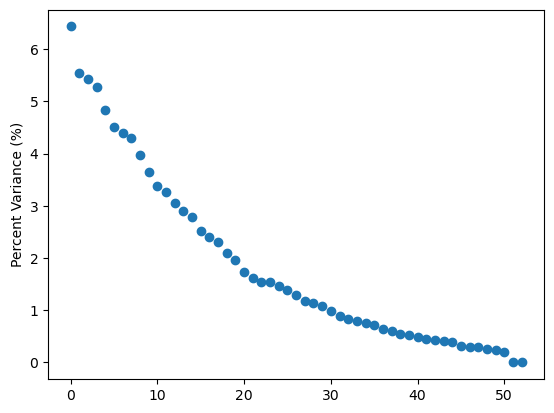

In [13]:
n_components = 53
W_ = np.copy(dat)
pca = PCA(n_components = n_components) 
covar_matrix = pca.fit(W_)
variances = covar_matrix.explained_variance_ratio_ # Var ratios
plt.scatter(range(n_components), variances*100)
plt.ylabel('Percent Variance (%)')